# Contact networks from mask overlap

In [2]:
import sys
from copy import deepcopy
from pathlib import Path

sys.path.append("../scripts/")

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
from helpers_various import time_str_to_time_s
from scipy.spatial.distance import squareform
from segmentations import Segmentations
from utils_cleaning import smooth_seg_dict, subtract_center_of_mass_seg_dict
from utils_draw import (
    compute_fig_lims,
    plot_frame,
    plot_graph,
    plot_graphx,
    plot_masks,
    plot_orientations,
    plot_presence,x
    plot_trajectories,
    calculate_window_widths, 
    plot_time_series_by_window,
    plot_series_distribution,
    plot_convex_hull,
    plot_time_series_by_window_fill_between
)
from utils_io import convert_to_dict
from utils_networks import *
from utils_sync import (
    compute_view_intersections,
    compute_view_lines,
    diving_order,
    find_stable_periods,
    order_parameter
) 

sb.set_theme(style="ticks", context="paper")


results_dir = "../results/contact/"
data_dir = "../data/pre-birth/"

Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)

%load_ext autoreload
%autoreload 2

/home/lucasm/.pyenv/versions/3.9.19/envs/venv_ceti/lib/python3.9/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Load all segmentation files

In [3]:
import glob 

In [4]:
data_files = glob.glob("../data/*/1688*.hdf5")
data_files

['../data/late/1688841618482_segmentations_max_names.hdf5',
 '../data/pre-birth/1688830733272_segmentations_max_merges.hdf5',
 '../data/pre-birth/1688827660979_segmentations.hdf5',
 '../data/pre-birth/1688829151574_segmentations.hdf5',
 '../data/pre-birth/1688830960531_segmentations_198backup.hdf5',
 '../data/pre-birth/1688827433752_segmentations.hdf5',
 '../data/pre-birth/1688828965144_segmentations.hdf5',
 '../data/pre-birth/1688829193016_segmentations.hdf5',
 '../data/pre-birth/1688827887072_segmentations.hdf5',
 '../data/post-birth/1688832767759_segmentations.hdf5',
 '../data/post-birth/1688831830406_segmentations.hdf5',
 '../data/post-birth/1688832540499_segmentations.hdf5',
 '../data/post-birth/1688832995052_segmentations_max_merges.hdf5',
 '../data/post-birth/1688831602631_segmentations.hdf5',
 '../data/during-birth/1688831228731_segmentations_postUpgradeFormat.hdf5',
 '../data/during-birth/1688831187858_segmentations_postUpgradeFormat.hdf5',
 '../data/during-birth/1688831374924

In [5]:
vid_numbers = [file_name.split("/")[-1].split("_")[0] for file_name in data_files]
sorted_vid_idcs = np.argsort(vid_numbers)
vid_numbers = list(np.sort(vid_numbers))
vid_numbers

['1688827433752',
 '1688827660979',
 '1688827887072',
 '1688828965144',
 '1688829151574',
 '1688829193016',
 '1688830733272',
 '1688830960531',
 '1688831187858',
 '1688831228731',
 '1688831374924',
 '1688831602631',
 '1688831830406',
 '1688832540499',
 '1688832767759',
 '1688832995052',
 '1688841618482']

In [6]:
clean_seg_files = glob.glob("../data/*cleaned.pkl")
clean_seg_files = sorted(clean_seg_files)
clean_seg_files

vid_numbers = [file_name.split("/")[-1][:-12] for file_name in clean_seg_files]
vid_numbers

['1688827433752',
 '1688827660979',
 '1688827887072',
 '1688828965144',
 '1688829151574',
 '1688829193016',
 '1688830733272',
 '1688830960531',
 '1688831187858',
 '1688831228731',
 '1688831374924',
 '1688831602631',
 '1688831830406',
 '1688832540499',
 '1688832767759',
 '1688832995052',
 '1688841618482_1',
 '1688841618482_2']

In [7]:
whens = [file_name.split("/")[2].split("-")[0] for file_name in data_files]
whens = list(np.array(whens)[sorted_vid_idcs])
data_files = list(np.array(data_files)[sorted_vid_idcs])
whens

['pre',
 'pre',
 'pre',
 'pre',
 'pre',
 'pre',
 'pre',
 'pre',
 'during',
 'during',
 'during',
 'post',
 'post',
 'post',
 'post',
 'post',
 'late']

In [8]:
import pickle 

segmentations = {}

for vid_number in vid_numbers:

    file_name = f"../data/{vid_number}_cleaned_with_masks.pkl"
    with open(file_name, "rb") as fp:
        segmentation = pickle.load(fp)

        segmentations[vid_number] = segmentation

In [9]:
adjacency_matrices = {}

for vid_number in vid_numbers:

    print(vid_number)

    seg = segmentations[vid_number]

    # build adjacency based on masks distances or overlaps
    adj_masks = build_adjacency(seg, masks_polygon_overlap, default_value=0)
    
    # set diagonals to 0 again
    for i in range(adj_masks.shape[0]):
        np.fill_diagonal(adj_masks[i, :, :], 0)

    adjacency_matrices[vid_number] = adj_masks
    
        

1688827433752


100%|██████████| 3800/3800 [01:53<00:00, 33.56it/s]


1688827660979


100%|██████████| 5627/5627 [01:48<00:00, 51.79it/s]


1688827887072


100%|██████████| 1000/1000 [00:10<00:00, 98.27it/s]


1688828965144


100%|██████████| 4750/4750 [01:26<00:00, 55.07it/s]


1688829151574


100%|██████████| 1202/1202 [00:07<00:00, 170.22it/s]


1688829193016


100%|██████████| 3000/3000 [00:38<00:00, 78.23it/s] 


1688830733272


100%|██████████| 5000/5000 [00:27<00:00, 181.49it/s]


1688830960531


100%|██████████| 4000/4000 [00:19<00:00, 205.74it/s]


1688831187858


100%|██████████| 32/32 [00:00<00:00, 223.49it/s]


1688831228731


100%|██████████| 206/206 [00:07<00:00, 29.14it/s]


1688831374924


100%|██████████| 179/179 [00:03<00:00, 45.12it/s]


1688831602631


100%|██████████| 341/341 [00:08<00:00, 40.62it/s]


1688831830406


100%|██████████| 182/182 [00:03<00:00, 49.33it/s]


1688832540499


100%|██████████| 154/154 [00:06<00:00, 22.73it/s]


1688832767759


100%|██████████| 171/171 [00:06<00:00, 24.95it/s]


1688832995052


100%|██████████| 170/170 [00:07<00:00, 22.60it/s]


1688841618482_1


100%|██████████| 2500/2500 [00:22<00:00, 111.74it/s]


1688841618482_2


100%|██████████| 1200/1200 [00:07<00:00, 162.27it/s]


In [ ]:
# save to file
import pickle 

file_name = f"../results/adjacency_matrices_contact.pkl"
with open(file_name, "wb") as fp:
    pickle.dump(adjacency_matrices, fp)

In [8]:
# load from file 
import pickle 

file_name = f"../results/adjacency_matrices_contact.pkl"
with open(file_name, "rb") as fp:
    adjacency_matrices = pickle.load(fp)

In [9]:
segg = segmentations["1688828965144"]

segg["segmentation_frequency"]

[72, 1]

In [10]:
segg.keys()

dict_keys(['bounding_boxes', 'centroids', 'orientations_rad', 'orientations_confidence', 'frame_indices', 'timestamps_s', 'timestamps_s_babyTime', 'timestamps_str', 'num_whales', 'num_frames', 'num_whales_over_time', 'ids', 'id_numbers', 'are_frames_segmented', 'fps', 'segmentation_frequency', 'total_time', 'masks_arrays', 'masks_polygons'])

In [11]:
320 / 30 

10.666666666666666

In [12]:
gcc_sizes = {}
ns_whales = {}
ns_edges = {}
rsyncs = {}

window_goal = 320 * 2 #160 # in consecutive frames
print(f"running window in seconds: {window_goal / 30}")

for vid_number in vid_numbers:

    seg = segmentations[vid_number]

    seg_freq = seg["segmentation_frequency"]

    # build adjacency based on masks distances or overlaps
    adj_masks = adjacency_matrices[vid_number]
    
    # set diagonals to 0 again
    for i in range(adj_masks.shape[0]):
        np.fill_diagonal(adj_masks[i, :, :], 0)

    gcc_size = np.zeros(seg["num_frames"])
    #Ns = np.zeros(seg["num_frames"])
    Ms = np.zeros(seg["num_frames"])

    for t in range(seg["num_frames"]):
    
        G = nx.Graph(adj_masks[t])
        
        # identify largest connected component
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        n_gcc = len(G0)

        gcc_size[t] = n_gcc
        #Ns[t] = len(G.nodes)
        Ms[t] = len(G.edges)
        

    vals, counts = np.unique(np.diff(seg["frame_indices"]), return_counts=True)

    #print(set(vals), set(seg_freq))

    if len(vals)==1 :
        freq = vals[0]
        window = int(window_goal / freq)
    elif min(counts) < 20:
        freq = vals[np.argmax(counts)]
        window = int(window_goal / freq)
        print("=====", vid_number, freq)
    else: 
        window = int(window_goal)
        print("+++", seg_freq)
        print(vals, counts)
        
    print(vid_number, vals, counts,  window)

    rsync = order_parameter(seg["orientations_rad"], axis=1, order=1)

    min_periods = int(window / 4)
    gcc_size = pd.Series(gcc_size).rolling(window=window, min_periods=min_periods).mean()
    n_whales_time = pd.Series(num_whales_over_time(seg["orientations_rad"])).rolling(window=window, min_periods=min_periods).mean()
    Ms = pd.Series(Ms).rolling(window=window, min_periods=min_periods).mean()  
    rsync = pd.Series(rsync).rolling(window=window, min_periods=min_periods).mean()


    gcc_sizes[vid_number] = gcc_size
    ns_whales[vid_number] = n_whales_time
    ns_edges[vid_number] = Ms
    rsyncs[vid_number] = rsync
     

running window in seconds: 21.333333333333332
1688827433752 [1] [3799] 640
1688827660979 [1] [5626] 640
1688827887072 [1] [999] 640
1688828965144 [1] [4749] 640
1688829151574 [1] [1201] 640
1688829193016 [1] [2999] 640
1688830733272 [1] [4999] 640
1688830960531 [1] [3999] 640
===== 1688831187858 20
1688831187858 [20 40] [30  1] 32
===== 1688831228731 20
1688831228731 [20 40] [204   1] 32
===== 1688831374924 40
1688831374924 [20 40] [ 16 162] 16
===== 1688831602631 20
1688831602631 [20 40] [339   1] 32
1688831830406 [20] [181] 32
===== 1688832540499 40
1688832540499 [ 40 120] [152   1] 16
1688832767759 [40] [170] 16
===== 1688832995052 40
1688832995052 [40 80] [168   1] 16
1688841618482_1 [1] [2499] 640
1688841618482_2 [1] [1199] 640


In [13]:
df_gcc_sizes = pd.DataFrame.from_dict(gcc_sizes, orient='index')
df_n_whales = pd.DataFrame.from_dict(ns_whales, orient='index')
df_ns_edges = pd.DataFrame.from_dict(ns_edges, orient='index')
df_rsync = pd.DataFrame.from_dict(rsyncs, orient='index')

df_gcc_sizes_long = df_gcc_sizes.melt(ignore_index=False, var_name="frame", value_name="gcc_size")
df_n_whales_long = df_n_whales.melt(ignore_index=False, var_name="frame", value_name="n_whales")
df_ns_edges_long = df_ns_edges.melt(ignore_index=False, var_name="frame", value_name="n_edges")
df_rsync_long = df_rsync.melt(ignore_index=False, var_name="frame", value_name="rsync")

df_n_whales_long

,frame,n_whales
1688827433752,0,NaN
1688827660979,0,NaN
1688827887072,0,NaN
1688828965144,0,NaN
1688829151574,0,NaN
...,...,...
1688832540499,5626,NaN
1688832767759,5626,NaN
1688832995052,5626,NaN
1688841618482_1,5626,NaN


In [14]:
timestamps_s = {}
timestamps_s_babyTime = {}
timestamps_str = {}

for vid_number in vid_numbers:

    seg = segmentations[vid_number]

    timestamps_s[vid_number] = seg["timestamps_s"]
    timestamps_s_babyTime[vid_number] = seg["timestamps_s_babyTime"]
    timestamps_str[vid_number] = seg["timestamps_str"]

In [15]:
df_timestamps = pd.DataFrame.from_dict(timestamps_s, orient='index')
df_timestamps_s_babyTime = pd.DataFrame.from_dict(timestamps_s_babyTime, orient='index')
df_timestamps_str = pd.DataFrame.from_dict(timestamps_str, orient='index')

df_timestamps_long = df_timestamps.melt(ignore_index=False, var_name="frame", value_name="timestamps_s")
df_timestamps_s_babyTime_long = df_timestamps_s_babyTime.melt(ignore_index=False, var_name="frame", value_name="timestamps_s_babyTime")
df_timestamps_str_long = df_timestamps_str.melt(ignore_index=False, var_name="frame", value_name="timestamps_str")

df_timestamps_str_long

,frame,timestamps_str
1688827433752,0,2023-07-08 10:45:21.303590 -0400
1688827660979,0,2023-07-08 10:47:41.777590 -0400
1688827887072,0,2023-07-08 10:51:27.870590 -0400
1688828965144,0,2023-07-08 11:10:07.649590 -0400
1688829151574,0,2023-07-08 11:12:37.671219 -0400
...,...,...
1688832540499,5626,None
1688832767759,5626,None
1688832995052,5626,None
1688841618482_1,5626,None


In [16]:
# the following crashes
#df_long = pd.merge(df_gcc_sizes_long, df_n_whales_long, left_index=True, right_index=True, how="left")

# so we merge manually because too many elements
df_long = df_gcc_sizes_long.copy()
df_long["n_edges"] = df_ns_edges_long["n_edges"]
df_long["n_whales"] = df_n_whales_long["n_whales"]
df_long["rsync"] = df_rsync_long["rsync"]

df_long["timestamps_s"] = df_timestamps_long["timestamps_s"]
df_long["timestamps_s_babyTime"] = df_timestamps_s_babyTime_long["timestamps_s_babyTime"]
df_long["timestamps_str"] = df_timestamps_str_long["timestamps_str"]
df_long

,frame,gcc_size,n_edges,n_whales,rsync,timestamps_s,timestamps_s_babyTime,timestamps_str
1688827433752,0,NaN,NaN,NaN,NaN,1.688828e+09,-3623.696410,2023-07-08 10:45:21.303590 -0400
1688827660979,0,NaN,NaN,NaN,NaN,1.688828e+09,-3483.222410,2023-07-08 10:47:41.777590 -0400
1688827887072,0,NaN,NaN,NaN,NaN,1.688828e+09,-3257.129410,2023-07-08 10:51:27.870590 -0400
1688828965144,0,NaN,NaN,NaN,NaN,1.688829e+09,-2137.350410,2023-07-08 11:10:07.649590 -0400
1688829151574,0,NaN,NaN,NaN,NaN,1.688829e+09,-1987.328781,2023-07-08 11:12:37.671219 -0400
...,...,...,...,...,...,...,...,...
1688832540499,5626,NaN,NaN,NaN,NaN,NaN,NaN,None
1688832767759,5626,NaN,NaN,NaN,NaN,NaN,NaN,None
1688832995052,5626,NaN,NaN,NaN,NaN,NaN,NaN,None
1688841618482_1,5626,NaN,NaN,NaN,NaN,NaN,NaN,None


In [17]:
# compute normalized versions
df_long["gcc_size_norm"] = df_long["gcc_size"] / df_long["n_whales"]
df_long["n_edges_norm"] = df_long["n_edges"] / df_long["n_whales"]

df_long["net_density"] = df_long["n_edges"] / (df_long["n_whales"] * (df_long["n_whales"] - 1))

df_long = df_long.reset_index()
df_long.rename(columns={'index':"video_number"}, inplace=True)

df_long

,video_number,frame,gcc_size,n_edges,n_whales,rsync,timestamps_s,timestamps_s_babyTime,timestamps_str,gcc_size_norm,n_edges_norm,net_density
0,1688827433752,0,NaN,NaN,NaN,NaN,1.688828e+09,-3623.696410,2023-07-08 10:45:21.303590 -0400,NaN,NaN,NaN
1,1688827660979,0,NaN,NaN,NaN,NaN,1.688828e+09,-3483.222410,2023-07-08 10:47:41.777590 -0400,NaN,NaN,NaN
2,1688827887072,0,NaN,NaN,NaN,NaN,1.688828e+09,-3257.129410,2023-07-08 10:51:27.870590 -0400,NaN,NaN,NaN
3,1688828965144,0,NaN,NaN,NaN,NaN,1.688829e+09,-2137.350410,2023-07-08 11:10:07.649590 -0400,NaN,NaN,NaN
4,1688829151574,0,NaN,NaN,NaN,NaN,1.688829e+09,-1987.328781,2023-07-08 11:12:37.671219 -0400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
101281,1688832540499,5626,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
101282,1688832767759,5626,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
101283,1688832995052,5626,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
101284,1688841618482_1,5626,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [18]:
df_long = df_long.sort_values(by="timestamps_s_babyTime")
df_long = df_long.dropna(subset=['timestamps_s_babyTime'])

In [19]:
series = df_long["gcc_size_norm"]
ts = df_long["timestamps_s_babyTime"]

In [20]:
import h5py

# Open the data file.
h5_file = h5py.File('../results/contact/cohesion_data.hdf5', 'r')

h5_group = h5_file['cohesion_timeseries']
time_s = np.array(h5_group['time_s'])
cohesion_score = np.array(h5_group['cohesion_score'])
cohesion_score_smoothed = np.array(h5_group['cohesion_score_smoothed_20s'])

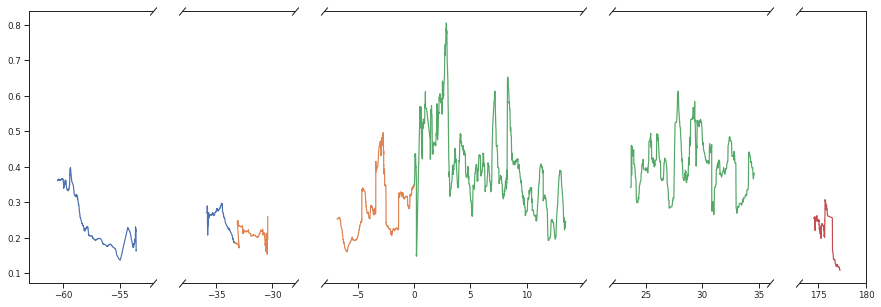

In [21]:
#time_windows = [(0, 10), (30, 40), (40, 60), (60, 80), (80, 100)]

birth_start = -2000 / 60
birth_end = 0
later = 5000 / 60

# Define a simple time-phase mapping
def time_phase_mapping(t):
    if t < birth_start:
        return "pre"
    elif birth_start <= t and t < birth_end:
        return "during"
    elif birth_end <= t and t < later:
        return "post"
    elif t >= later:
        return "later"


plot_regions_xlims_s = np.array([
    [-3780.0, -3120.0],
    [-2280.0, -1680.0],
    [-480.0, 900.0],
    [1320.0, 2160.0],
    [10380.0, 10740.0],
]) / 60

# Call the function
fig, axs = plot_time_series_by_window(
    cohesion_score_smoothed,
    times=time_s / 60,
    time_windows=plot_regions_xlims_s,
    time_phase_mapping=time_phase_mapping,
    show_legend=False,
    
)

axs[1].set_xticks([-35, -30])
axs[2].set_xticks([-5, 0, 5, 10])
axs[4].set_xticks([175, 180])
#axs[4].tick_params(axis='y', labelright=False)

plt.show()

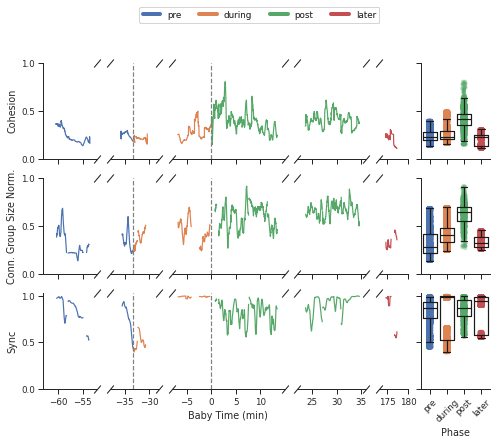

In [23]:
series2 = df_long["gcc_size_norm"]
series3 = df_long["rsync"]
times = df_long["timestamps_s_babyTime"] 

birth_start = -2000 / 60
birth_end = 0 
later = 5000 / 60

# Define a simple time-phase mapping
def time_phase_mapping(t):
    if t < birth_start :
        return "pre"
    elif birth_start <= t and t < birth_end:
        return "during"
    elif birth_end <= t and t < later:
        return "post"
    elif t >= later:
        return "later"


time_windows = np.array([
    [-3780.0, -3120.0],
    [-2280.0, -1680.0],
    [-480.0, 900.0],
    [1320.0, 2160.0],
    [10380.0, 10740.0],
]) / 60

ratios = calculate_window_widths(time_windows)
series = [cohesion_score_smoothed, series2, series3]
times_arr = [time_s, times, times]
ncols =  len(time_windows)+1
nrows = len(series)

test_pairs = [("pre", "during"), ("during", "post"), ("post", "later")]
test = "Mann-Whitney" #"t-test_welc"

fig, axs = plt.subplots(nrows, ncols, sharey="row", sharex="col", width_ratios=ratios+[ratios[3]], figsize=(8, 6))#, layout="constrained")
   
for i in range(nrows): 

    plot_time_series_by_window(series[i], times_arr[i] / 60, time_windows=time_windows, time_phase_mapping=time_phase_mapping, axs=axs[i,:-1])
    plot_series_distribution(series[i], times_arr[i] / 60, time_phase_mapping, ax=axs[i,-1], show_tests=False, 
                            test_pairs=test_pairs, test=test)

for ax in axs.ravel():
    pass
    #ax.grid(zorder=-10)

#plot_time_series_by_window(df_long["n_whales"], times / 60, time_windows=time_windows, time_phase_mapping=time_phase_mapping, axs=axs[1,:-1], alpha=0.3)


axs[0,0].set_ylabel("Cohesion")
axs[0,0].set_yticks([0, 0.5, 1])

axs[1,0].set_ylabel("Conn. Group Size Norm.")
axs[1,0].set_yticks([0, 0.5, 1])
#axs[1,0].set_yticks([2, 6, 10])

axs[2,0].set_ylabel("Sync")
axs[2,0].set_yticks([0, 0.5, 1])

axs[2,2].set_xticks([-5, 0, 5, 10])
axs[2,4].set_xticks([175, 180])

axs[2,2].set_xlabel("Baby Time (min)")

for ax in axs[:,2]:
    ax.axvline(x=birth_end, c="grey", ls="--")
for ax in axs[:,1]:
    ax.axvline(x=birth_start, c="grey", ls="--")

axs[2,-1].set_xticks(axs[2,-1].get_xticks(), axs[2,-1].get_xticklabels(), rotation=45, ha='center')

for axi in axs[:,-1]:
    sb.despine(ax=axi)

for axi in axs[:, :-1].ravel():
    spine_names = ('top','right')
    for spine_name in spine_names:
        axi.spines[spine_name].set_visible(False)

# axs[0,1].axvline(x=bb_time1 / 60, c="r", ls="-")
# axs[0,2].axvline(x=bb_time2 / 60, c="r", ls="-")
# axs[0,2].axvline(x=bb_time3 / 60, c="r", ls="-")
# axs[0,4].axvline(x=bb_time4 / 60, c="r", ls="-")

fig_name = f"fig_2_v4"
plt.savefig(f"{results_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight", facecolor="w")

plt.show()

pre vs. during: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.902e-22 U_stat=1.304e+08
during vs. post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=3.772e+06
post vs. later: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=8.802e+06
pre vs. post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=2.766e+06
during vs. later: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.335e-146 U_stat=4.502e+07
pre vs. later: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.811e-143 U_stat=4.111e+07
pre vs. during: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=4.933e+07
during vs. post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:0.000e+00 U_stat=1.898e+06
post vs. later: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_va

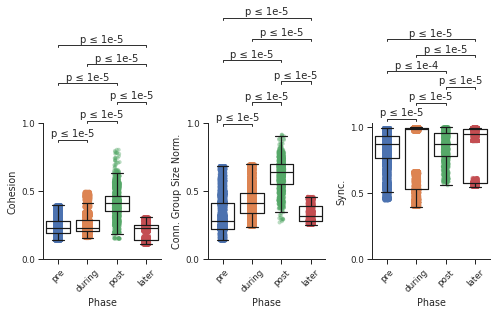

In [24]:
fig, axs = plt.subplots(1, 3, sharey=False, figsize=(8, 2.5))#, layout="constrained")


test_pairs = [("pre", "during"), ("during", "post"), ("post", "later"), ("pre", "later"), ("pre", "post"), ("during", "later")]
test = "Mann-Whitney" #"Mann-Whitney" #"t-test_welc"

titles = ["Cohesion", "Conn. Group Size Norm.", "Sync."]

for i, ax in enumerate(axs):

    plot_series_distribution(
        series[i],
        times_arr[i] / 60,
        time_phase_mapping,
        ax=ax,
        show_tests=True,
        test_pairs=test_pairs,
        test=test,
    )

    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='center')
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylabel(titles[i])

sb.despine()

plt.subplots_adjust(wspace=0.4)

fig_name = f"fig_s2_stats"
plt.savefig(f"{results_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight", facecolor="w")


In [1]:
import pingouin as pg

In [38]:
from scipy.stats import kstest, ks_2samp

In [41]:
ks_2samp(series[0], series[1], nan_policy="omit")

KstestResult(statistic=0.42533833145959826, pvalue=0.0, statistic_location=0.28096142219205106, statistic_sign=1)

<Axes: xlabel='Phase', ylabel='Value'>

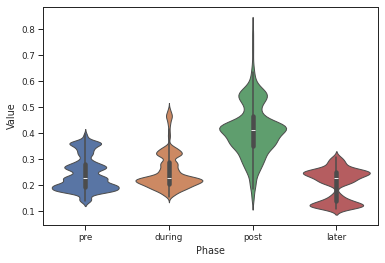

In [28]:
jj = 0
data = pd.DataFrame({
        'Time': times_arr[jj] / 60,
        'Value': series[jj],
        'Phase': [time_phase_mapping(t) for t in times_arr[jj] / 60]
    })

data = data.dropna()

sb.violinplot(data=data, y="Value", x="Phase", hue="Phase")

In [32]:
data.groupby("Phase").count()

,Time,Value
Phase,,
during,17454,17454
later,4100,4100
post,2219,2219
pre,15943,15943


In [49]:
pg.kruskal(data, dv="Value", between="Phase", detailed=True )

,Source,ddof1,H,p-unc
Kruskal,Phase,3,7449.037139,0.0


In [ ]:
pg.compute_effsize'

In [53]:
pg.pairwise_tests(data=data, dv="Value", between="Phase", effsize="cohen", parametric=False, padjust="bonf")

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,cohen
0,Phase,during,later,False,False,32188827.0,two-sided,0.000000e+00,0.000000e+00,bonf,0.815439
1,Phase,during,post,False,False,1898415.0,two-sided,0.000000e+00,0.000000e+00,bonf,-1.895679
2,Phase,during,pre,False,False,134238190.0,two-sided,0.000000e+00,0.000000e+00,bonf,0.761688
3,Phase,later,post,False,False,93965.5,two-sided,0.000000e+00,0.000000e+00,bonf,-3.604677
4,Phase,later,pre,False,False,28406999.5,two-sided,1.140151e-78,6.840905e-78,bonf,0.066177
5,Phase,post,pre,False,False,18309089.0,two-sided,0.000000e+00,0.000000e+00,bonf,2.362920


In [141]:
segmentations.keys()

dict_keys(['1688827433752', '1688827660979', '1688827887072', '1688828965144', '1688829151574', '1688829193016', '1688830733272', '1688830960531', '1688831187858', '1688831228731', '1688831374924', '1688831602631', '1688831830406', '1688832540499', '1688832767759', '1688832995052', '1688841618482_1', '1688841618482_2'])

baby time = -56.39
baby time = -6.80
baby time = 4.87
baby time = 176.63


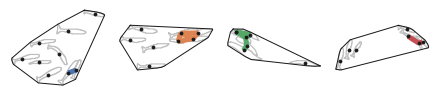

In [163]:
fig, axs_top = plt.subplots(1, 4, figsize=(6, 3), sharex=False, layout="constrained")

ax = axs_top[0]
frame = 3000
vid_number = "1688827660979" #"1688829193016"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, colors="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C0", zorder=2, ax=ax)
plot_convex_hull(seg, frame, ax=ax, lw=1, c="k", ls="-")

mmask = (df_long["frame"]==frame) * (df_long["video_number"]==vid_number)
bb_time1 = df_long[mmask]["timestamps_s_babyTime"].values[0]
print(f"baby time = {bb_time1 / 60:.2f}")

ax = axs_top[1]
frame = 50
vid_number = "1688830733272"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, colors="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C1", zorder=2, ax=ax)
plot_convex_hull(seg, frame, ax=ax, lw=1, c="k", ls="-")

mmask = (df_long["frame"]==frame) * (df_long["video_number"]==vid_number)
bb_time2 = df_long[mmask]["timestamps_s_babyTime"].values[0]
print(f"baby time = {bb_time2 / 60:.2f}")

ax = axs_top[2]
frame = 50
vid_number = "1688831374924"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, colors="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C2", zorder=2, ax=ax)
plot_convex_hull(seg, frame, ax=ax, lw=1, c="k", ls="-")

mmask = (df_long["frame"]==frame) * (df_long["video_number"]==vid_number)
bb_time3 = df_long[mmask]["timestamps_s_babyTime"].values[0]
print(f"baby time = {bb_time3 / 60:.2f}")

ax = axs_top[3]
frame = 30
vid_number = "1688841618482_2"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, colors="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C3", zorder=2, ax=ax)
plot_convex_hull(seg, frame, ax=ax, lw=1, c="k", ls="-")

mmask = (df_long["frame"]==frame) * (df_long["video_number"]==vid_number)
bb_time4 = df_long[mmask]["timestamps_s_babyTime"].values[0]
print(f"baby time = {bb_time4 / 60:.2f}")

for ax in axs_top:
    ax.set_yticks([])
    ax.set_xticks([])

sb.despine(left=True, bottom=True)


fig_name = f"fig_2_insets"
plt.savefig(f"{results_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight", facecolor="w")


In [1]:
df_metadata = pd.read_csv("../data/videos_metadata.csv", sep="\t")
keep = ["video_number", "start", "end"]
df_metadata = df_metadata[keep]
df_metadata

NameError: name 'pd' is not defined

In [ ]:
from datetime import time

birth_start = time(11, 12, 45)
birth_end = time(11, 45, 45)
later = time(14, 0, 0)

def assign_period(t):
    if t < birth_start:
        return "pre"
    elif birth_start <= t and t < birth_end:
        return "during"
    elif birth_end <= t and t < later:
        return "post"
    elif t >= later:
        return "late"



In [ ]:
df_summary = pd.merge(left=df_long, right=df_metadata, left_on="video_number", right_on="video_number", how="left")
df_summary['start'] = pd.to_datetime(df_summary['start'], format='%H:%M:%S').dt.time

df_summary["when"] = df_summary["start"].apply(assign_period)
#summary_df['start'] = pd.to_datetime(df_summary['start'], format='%H:%M:%S')
df_summary['start'] = pd.to_datetime(df_summary['start'], format='%H:%M:%S').apply(lambda x: x.replace(year=2024, month=1, day=1))

df_summary

In [9]:
# remove rows with all nans (so that we have the right number of frames for each video)
df_summary = df_summary.dropna(subset=["n_whales", "gcc_size", "n_edges"], how="all")

df_summary.shape
# check with 
#df_summary.groupby("video_number").count()

NameError: name 'df_summary' is not defined

In [10]:
keep_cols = ["video_number", "start", "end", "when"]
df_median = df_summary.groupby(keep_cols).median().reset_index()
df_mean = df_summary.groupby(keep_cols).mean().reset_index()
df_std = df_summary.groupby(keep_cols).std().reset_index()

NameError: name 'df_summary' is not defined

In [11]:
df_mean

NameError: name 'df_mean' is not defined

In [ ]:
mask = df_summary["when"] == "during"
mask_vid = df_summary["video_number"] == "1688829151574"

In [ ]:
df_summary["timestamps_str"].unique()

In [ ]:
df_summary = df_summary.sort_values("timestamps_s")

In [ ]:
#df_summary["gcc_size_norm"] = df_summary["gcc_size_norm"].rolling(window=100).mean()
df_summary["net_density"] = df_summary["net_density"].rolling(window=100).mean()

In [ ]:

xlims = [(-3700, -3200), (-2200, -1800), (-500, 800), (1400, 2100), (10450, 10650)]
deltas = np.diff(xlims).flatten()
i_min = np.argmin(deltas)

ratios = [delta / deltas[i_min] for delta in deltas] + [3]

fig, axs = plt.subplots(1, 5 + 1, sharey=True, figsize=(15, 4), width_ratios=ratios)
n_plots = len(xlims)

y = "rsync"

for i in range(n_plots):

    ax = axs[i]
    sb.lineplot(data=df_summary, y=y, x="timestamps_s_babyTime", hue="when", ax=ax, legend=i==3)

    ax.set_xlim(xlims[i])
    ax.set_xlabel("")
    sb.despine(ax=ax, left=i!=0, top=False, right=i!=n_plots-1)

d = .7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
for i in range(n_plots-1):
    axs[i].plot([1, 1], [0, 1], transform=axs[i].transAxes, **kwargs)
for i in range(1,n_plots):
    axs[i].plot([0, 0], [0, 1], transform=axs[i].transAxes, **kwargs)


plot_distribution(df=df_summary, var="rsync", ax=axs[-1])


fig.supxlabel("Baby Epoch Time (s)")

fig_name = f"{y}_over_time_broken"
plt.savefig(f"{results_dir}{fig_name}.png", dpi=250, bbox_inches="tight", facecolor="w")

plt.show()


In [ ]:
ratios

In [ ]:
import numpy as np

In [3]:
bins = np.arange(0.5, 10.5, 1)

In [4]:
bins

array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])

<Axes: ylabel='rsync'>

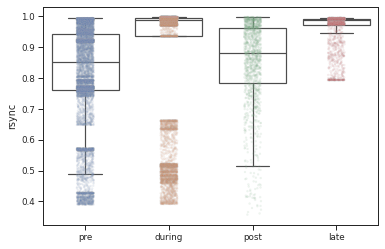

In [34]:
plot_distribution(df=df_summary, var="rsync")


IndexError: index 2 is out of bounds for axis 0 with size 2

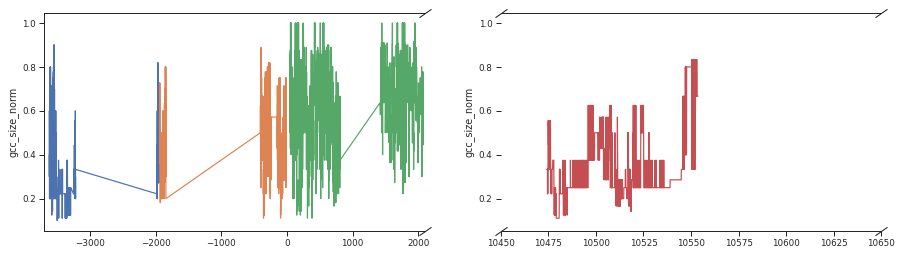

In [177]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15, 4))

xlims = [(-3700, 2100), (10450, 10650)]
n_plots = len(xlims) 

for i in range(n_plots):

    ax = axs[i]
    sb.lineplot(data=df_summary, y="gcc_size_norm", x="timestamps_s_babyTime", hue="when", ax=ax, legend=i==4)

    ax.set_xlim(xlims[i])
    ax.set_xlabel("")
    sb.despine(ax=ax, left=i!=0, top=False, right=i!=4)

    if i!=0 and i!=n_plots-1:
        #ax.set_yticks([])
        pass
d = .7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
for i in range(n_plots):
    axs[i].plot([1, 1], [0, 1], transform=axs[i].transAxes, **kwargs)
for i in range(1,n_plots+1):
    axs[i].plot([0, 0], [0, 1], transform=axs[i].transAxes, **kwargs)


fig.supxlabel("Baby Epoch Time (s)")

/tmp/ipykernel_9763/26136704.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[-1, 0].set_xticklabels(labels)


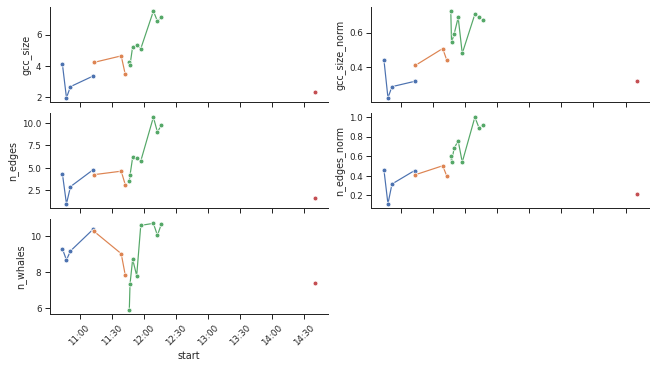

In [112]:
fig, axs = plt.subplots(3, 2, sharex=True, layout="constrained", figsize=(9, 5))

variables = ["gcc_size", "n_edges", "n_whales"]


for i, var in enumerate(variables):
    
    #sb.stripplot(data=df_summary, y=var, x="start", hue="when", ax=axs[i,0], legend=False, native_scale=True, alpha=0.3)
    #sb.boxplot(data=df_summary, y=var, x="start", hue="when", ax=axs[i,0], legend=False, native_scale=True, fliersize=0)
    sb.lineplot(data=df_mean, y=var, x="start", hue="when", marker="o", ax=axs[i,0], legend=False)

    #axs[i,0].errorbar(
    #        df_std["start"],
    #        df_mean[var],
    #        yerr=df_mean[var],
    #        fmt=".",
    #        capsize=5,
    #        #label=f"{category} error",
    #        alpha=0.6,
    #        ecolor="silver",
    #    )

    if var=="n_whales": # no n_whales_norm
        continue
        
    #sb.stripplot(data=df_summary, y=f"{var}_norm", x="start", hue="when", ax=axs[i,1], legend=False, native_scale=True, alpha=0.3)
    #sb.boxplot(data=df_summary, y=f"{var}_norm", x="start", hue="when", ax=axs[i,1], legend=False, native_scale=True, fliersize=0)
    sb.lineplot(data=df_mean, y=f"{var}_norm", x="start", hue="when", marker="o", ax=axs[i,1], legend=False)


axs[-1, 0].tick_params(axis='x', labelrotation=45)
axs[-1, 1].tick_params(axis='x', labelrotation=45)
labels = [item.get_text()[3:] for item in axs[-1, 0].get_xticklabels()]
axs[-1, 0].set_xticklabels(labels)
#labels = [item.get_text()[3:] for item in axs[-1, 1].get_xticklabels()]
#axs[-1, 1].set_xticklabels(labels)
#plt.xticks(rotation=45, ha="right")

axs[2, 1].remove()

sb.despine()


fig_name = f"density_all_box"
#plt.savefig(f"{results_dir}{fig_name}.png", dpi=250, bbox_inches="tight", facecolor="w")


plt.show()

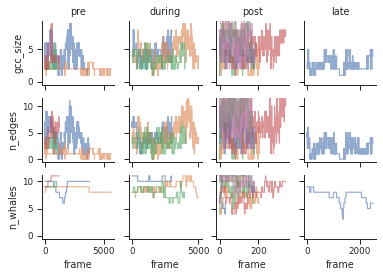

In [21]:
periods = list(df_summary["when"].unique())
variables = ['gcc_size', 'n_edges', 'n_whales']

fig, axs = plt.subplots(len(variables), len(periods), sharex="col", sharey="row")

for i, period in enumerate(periods):

    for j, var in enumerate(variables):

        ax = axs[j,i]
        
        mask_period = (df_summary["when"] == period)

        sb.lineplot(data=df_summary[mask_period], y=var, x="frame", hue="video_number", legend=False, ax=ax, alpha=0.6)

        ax.set_ylim(ymin=-0.5)

for i, ax in enumerate(axs[0,:]):
    ax.set_title(periods[i])

sb.despine()

fig_name = f"density_all_over_time"
#plt.savefig(f"{results_dir}{fig_name}.png", dpi=250, bbox_inches="tight", facecolor="w")


AttributeError: PathCollection.set() got an unexpected keyword argument 'legend'

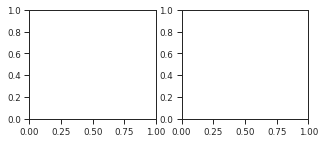

In [22]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(5, 2))

sb.stripplot(data=df_mean, y="gcc_size", x="when", hue="when", marker="o", legend=False, ax=ax)
sb.stripplot(data=df_mean, y="n_whales", x="when", hue="when", marker="o", legend=False, ax=ax2)

sb.despine()

fig_name = f"density_distributions"
plt.savefig(f"{results_dir}{fig_name}.png", dpi=250, bbox_inches="tight", facecolor="w")


plt.show()

In [ ]:
df_summary.groupby(["when", "video_number"]).count()

/home/lucasm/.pyenv/versions/3.9.19/envs/venv_ceti/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/lucasm/.pyenv/versions/3.9.19/envs/venv_ceti/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_12130/1482154667.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axd["D"].set_xticklabels(labels)


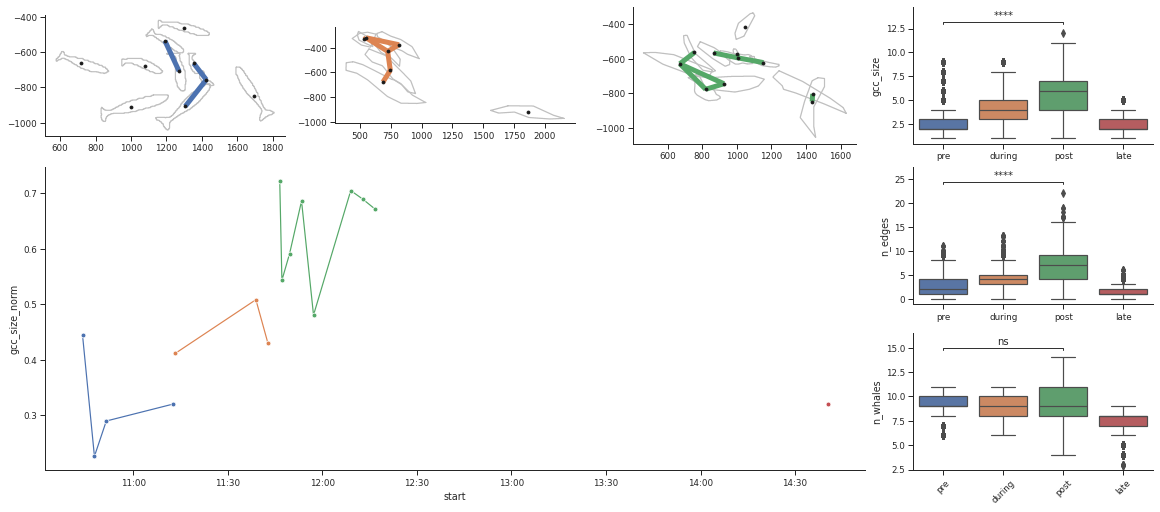

In [66]:
axd = plt.figure(layout="constrained", figsize=(16, 7)).subplot_mosaic(
    """
    ABCE
    DDDF
    DDDG
    """
)

ax = axd["A"]

frame = 1000
vid_number = "1688829193016"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C0", zorder=2, ax=ax)

ax = axd["B"]
frame = 50
vid_number = "1688831374924"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C1", zorder=2, ax=ax)

ax = axd["C"]
frame = 121
vid_number = "1688831830406"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C2", zorder=2, ax=ax)


ax = axd["D"]

sb.lineplot(data=df_mean, y="gcc_size_norm", x="start", hue="when", marker="o", ax=ax, legend=False)
labels = [item.get_text()[3:] for item in axd["D"].get_xticklabels()]
axd["D"].set_xticklabels(labels)

ax = axd["E"]
plot_distribution(df=df_summary, var="gcc_size", ax=ax)

ax = axd["F"]
plot_distribution(df=df_summary, var="n_edges", ax=ax)

ax = axd["G"]
plot_distribution(df=df_summary, var="n_whales", ax=ax)


ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='center')


sb.despine()

fig_name = f"fig_1_new"
plt.savefig(f"{results_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight", facecolor="w")


<Axes: >

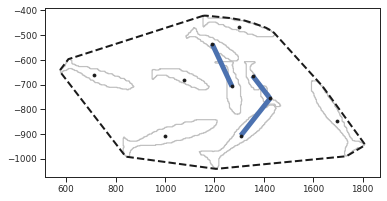

In [264]:
fig, ax = plt.subplots()

frame = 1000
vid_number = "1688829193016"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C0", zorder=2, ax=ax)


plot_convex_hull(seg, frame, ax=ax, lw=2, c="k", ls="--")

In [249]:
type(hy)

array.array

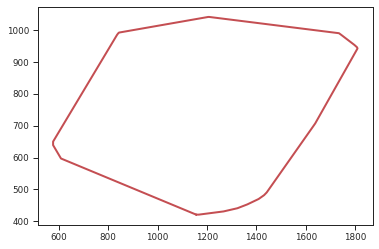

In [244]:

merged = unary_union(seg["masks_polygons"][frame])

# Compute the convex hull
convex_hull = merged.convex_hull
convex_hull

hx, hy = convex_hull.exterior.xy
plt.plot(hx, hy, 'r-', linewidth=2, label="Convex Hull")

/home/lucasm/.pyenv/versions/3.9.19/envs/venv_ceti/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/lucasm/.pyenv/versions/3.9.19/envs/venv_ceti/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


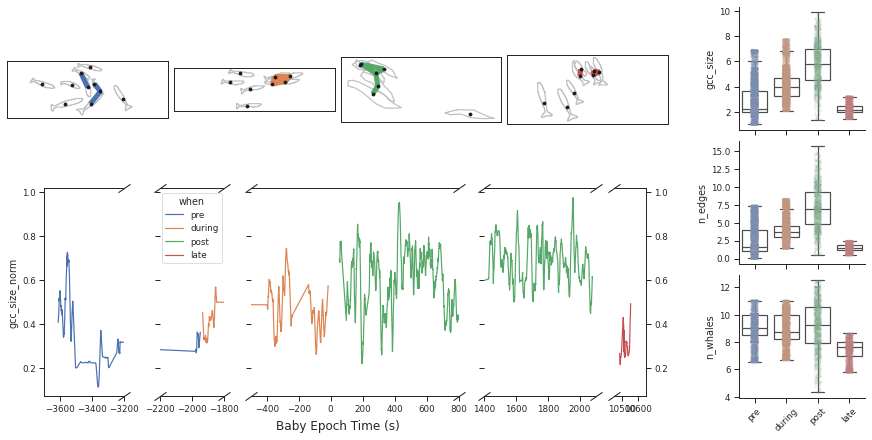

In [33]:

# layout definition
fig = plt.figure(layout='constrained', figsize=(12, 6))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[4, 1])

subfigs_left = subfigs[0].subfigures(2, 1, height_ratios=[1, 1.5])

axs_top = subfigs_left[0].subplots(1, 4, sharex=True)
axs_right = subfigs[1].subplots(3, 1, sharex=True)

#======= snapshots
ax = axs_top[0]

frame = 1000
vid_number = "1688829193016"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C0", zorder=2, ax=ax)

ax = axs_top[1]
frame = 50
vid_number = "1688830733272"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C1", zorder=2, ax=ax)

ax = axs_top[2]
frame = 50
vid_number = "1688831374924"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C2", zorder=2, ax=ax)

ax = axs_top[3]
frame = 60
vid_number = "1688841618482"
seg = segmentations[vid_number]
adj_contact = adjacency_matrices[vid_number]
plot_masks(seg, frame, c="silver", zorder=-1, ax=ax, show_labels=False)
plot_graphx(adj_contact[frame], seg, frame, center_type="masks", edge_color="C3", zorder=2, ax=ax)

for ax in axs_top:
    ax.set_yticks([])
    ax.set_xticks([])

#===== distributions
ax = axs_right[0]
plot_distribution(df=df_summary, var="gcc_size", ax=ax)

ax = axs_right[1]
plot_distribution(df=df_summary, var="n_edges", ax=ax)

ax = axs_right[2]
plot_distribution(df=df_summary, var="n_whales", ax=ax)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='center')

for ax in axs_right:
    sb.despine(ax=ax)

#========== timeline


xlims = [(-3700, -3200), (-2200, -1800), (-500, 800), (1400, 2100), (10450, 10650)]
deltas = np.diff(xlims).flatten()
i_min = np.argmin(deltas)

ratios = [delta / deltas[i_min] for delta in deltas]
n_plots = len(xlims)

axs_bottom = subfigs_left[1].subplots(1, n_plots, sharey=True, width_ratios=ratios)

for i in range(n_plots):

    ax = axs_bottom[i]
    sb.lineplot(data=df_summary, y="gcc_size_norm", x="timestamps_s_babyTime", hue="when", ax=ax, legend=i==1)

    ax.set_xlim(xlims[i])
    ax.set_xlabel("")
    sb.despine(ax=ax, left=i!=0, top=False, right=i!=n_plots-1)

#sb.move_legend(im, title="", loc="center top", n_cols=4)

d = .7  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
for i in range(n_plots-1):
    axs_bottom[i].plot([1, 1], [0, 1], transform=axs_bottom[i].transAxes, **kwargs)
for i in range(1,n_plots):
    axs_bottom[i].plot([0, 0], [0, 1], transform=axs_bottom[i].transAxes, **kwargs)


subfigs_left[1].supxlabel("Baby Epoch Time (s)")

fig_name = f"fig_1_new"
#plt.savefig(f"{results_dir}{fig_name}.pdf", dpi=250, bbox_inches="tight", facecolor="w")

#sb.despine()

plt.show()

In [31]:
df_summary

,video_number,frame,gcc_size,n_edges,n_whales,rsync,timestamps_s,timestamps_s_babyTime,timestamps_str,gcc_size_norm,n_edges_norm,net_density,start,end,when
5104,1688827433752,319,4.053125,6.137500,10.000000,0.974985,1.688828e+09,-3613.052410,2023-07-08 10:45:31.947590 -0400,0.405312,0.613750,NaN,2024-01-01 10:43:54,10:47:41,pre
5120,1688827433752,320,4.053125,6.137500,10.000000,0.975006,1.688828e+09,-3613.019410,2023-07-08 10:45:31.980590 -0400,0.405312,0.613750,NaN,2024-01-01 10:43:54,10:47:41,pre
5136,1688827433752,321,4.056250,6.137500,10.000000,0.975029,1.688828e+09,-3612.985410,2023-07-08 10:45:32.014590 -0400,0.405625,0.613750,NaN,2024-01-01 10:43:54,10:47:41,pre
5152,1688827433752,322,4.059375,6.140625,10.000000,0.975053,1.688828e+09,-3612.951410,2023-07-08 10:45:32.048590 -0400,0.405938,0.614062,NaN,2024-01-01 10:43:54,10:47:41,pre
5168,1688827433752,323,4.065625,6.150000,10.000000,0.975078,1.688828e+09,-3612.919410,2023-07-08 10:45:32.080590 -0400,0.406562,0.615000,NaN,2024-01-01 10:43:54,10:47:41,pre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39935,1688841618482,2495,2.831250,1.881250,5.825000,0.988687,1.688842e+09,10553.498701,2023-07-08 14:41:38.498701 -0400,0.486052,0.322961,0.056831,2024-01-01 14:40:18,14:44:02,late
39951,1688841618482,2496,2.837500,1.887500,5.821875,0.988642,1.688842e+09,10553.532701,2023-07-08 14:41:38.532701 -0400,0.487386,0.324208,0.056992,2024-01-01 14:40:18,14:44:02,late
39967,1688841618482,2497,2.843750,1.893750,5.818750,0.988597,1.688842e+09,10553.565701,2023-07-08 14:41:38.565701 -0400,0.488722,0.325456,0.057153,2024-01-01 14:40:18,14:44:02,late
39983,1688841618482,2498,2.850000,1.900000,5.815625,0.988552,1.688842e+09,10553.598701,2023-07-08 14:41:38.598701 -0400,0.490059,0.326706,0.057314,2024-01-01 14:40:18,14:44:02,late


In [32]:
def plot_distribution(df, var, ax=None):

    if ax is None:
        ax = plt.gca()

    sb.stripplot(data=df, y=var, x="when", ax=ax, hue="when", alpha=0.1, size=2, linewidth=0.5, edgecolor="silver")
    sb.boxplot(data=df, y=var, x="when", ax=ax, fliersize=0, boxprops=dict(facecolor='none'), zorder=2)

    ax.legend_.remove() 
        
    ax.set_ylabel(var)
    ax.set_xlabel("")
    
    from statannotations.Annotator import Annotator
    annotator = Annotator(
        ax,
        pairs=[("pre", "post")],
        data=df,
        x="when",
        y=var,
    )
    annotator.configure(
        test="t-test_welch", text_format="star", loc="inside", verbose=False, line_width=1
    )
    #annotator.apply_and_annotate()

    return ax